## 모듈 불러오기

In [ ]:
!pip install requests
!pip install folium
!pip install pulp

In [1]:
!pip install gurobipy

In [ ]:
import requests
import pandas as pd
import numpy as np
import itertools

import json
import re

import folium

import copy
from pulp import LpProblem, LpMaximize, LpVariable, LpInteger, LpBinary, lpSum, value
from sklearn.preprocessing import RobustScaler

import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'pulp'

## 데이터 로드 및 수정

### 데이터 관련 고민

In [ ]:
# 데이터 로드
file_path = '202404_버스노선별_정류장별_시간대별_승하차_인원_정보.csv'
data = pd.read_csv(file_path, encoding='cp949')

FileNotFoundError: [Errno 2] No such file or directory: '202404_버스노선별_정류장별_시간대별_승하차_인원_정보.csv'

In [ ]:
# '버스정류장ARS번호' 열을 문자열로 변환 (NaN 값 포함)
data['버스정류장ARS번호'] = data['버스정류장ARS번호'].astype(str)

# 정수로 변환할 수 없는 값 확인 (NaN 값 처리)
invalid_values = data[~data['버스정류장ARS번호'].str.isnumeric()]

print(invalid_values['버스정류장ARS번호'].unique())
print(invalid_values['버스정류장ARS번호'].info())

In [ ]:
file_path = '202404_버스노선별_정류장별_시간대별_승하차_인원_정보.csv'
data = pd.read_csv(file_path, encoding='cp949')

data = data[ data['버스정류장ARS번호'] != '~' ]

import copy

data_to_str = copy.deepcopy(data)
data_to_int = copy.deepcopy(data)

In [ ]:
data_to_str['버스정류장ARS번호'] = data_to_str['버스정류장ARS번호'].astype(str)

data_to_str = data_to_str[ data_to_str['버스정류장ARS번호'].str.startswith('8') ]

set_2_str = set(data_to_str['버스정류장ARS번호'].unique())

len(set_2_str), len(data_to_str)

In [ ]:
data_to_int['버스정류장ARS번호'] = data_to_int['버스정류장ARS번호'].astype(int)

data_to_int = data_to_int[ (data_to_int['버스정류장ARS번호']>=8000) & (data_to_int['버스정류장ARS번호']<9000) ]

set_2_int = set(data_to_int['버스정류장ARS번호'].astype(str).unique())

len(set_2_int), len(data_to_int)

In [ ]:
# 데이터 로드
file_path = '20240507 서울시 버스 정류소 위치 정보.xlsx'
data = pd.read_excel(file_path)

data = data[ (data['ARS_ID']>=8000) & (data['ARS_ID']<9000) ]
set_1 = set(data['ARS_ID'].astype(str).unique())

len(set_1), len(data)

In [ ]:
only_1 = set_1 - set_2_str
only_2 = set_2_str - set_1

display(only_1, only_2)

In [ ]:
only_1 = set_1 - set_2_int
only_2 = set_2_int - set_1

display(only_1, only_2)

### 진짜 데이터 로드 및 수정

In [ ]:
# 따릉이 대여소 위치 데이터 로드
file_path = '20240522 서울시 따릉이 대여소 마스터 정보.csv'
data = pd.read_csv(file_path, encoding='cp949')

# '주소1' 열에서 '성북구'가 포함된 행만 필터링
bike = data[data['주소1'].str.contains('성북')]

# 위도와 경도 모두 0이 아닌 데이터만 사용
bike = bike[ (bike['위도'] != 0) & (bike['경도'] != 0) ].reset_index(drop=True)

# 경도와 위도 열 위치 변경 / '주소2'열 삭제
bike.drop(columns=['주소2'], inplace=True)

# 필터링된 데이터 확인
bike

,대여소_ID,주소1,위도,경도
0,ST-947,서울특별시 성북구 보문로 168,37.589329,127.016434
1,ST-931,서울특별시 성북구 동소문로13길 38,37.591694,127.012497
2,ST-911,서울특별시 성북구 월곡로 지하 107,37.601841,127.041718
3,ST-910,서울특별시 성북구 월곡로 지하 107,37.602627,127.041634
4,ST-846,서울특별시 성북구 솔샘로17길 8,37.612774,127.006531
...,...,...,...,...
96,ST-1204,서울특별시 성북구 장위동 134-27,37.617844,127.055000
97,ST-1203,서울특별시 성북구 월계로 28,37.610569,127.033508
98,ST-1202,서울특별시 성북구 인촌로7길 24,37.586899,127.020752
99,ST-1201,서울특별시 성북구 인촌로7길 120,37.590382,127.017136


In [ ]:
# 성북구 버스 정류장 데이터 로드
file_path = '성북구 버스정류장 정보.xlsx'
data = pd.read_excel(file_path)

# 순위 기록한 행 삭제
data.dropna(how='any', inplace=True)

# 열 이름 변경
data.rename(columns={'버스정류장ARS번호':'ARS_ID','X좌표':'경도','Y좌표':'위도'}, inplace=True)

# candidate location 결정할 때, 필요없는 정보 삭제
to_drop_columns = {f'{hour}시 승하차 승객수' for hour in range(0,24,1)}
bus_location = data.drop(columns=to_drop_columns, inplace=False)

# 열 순서 바꾸기
bus_location = bus_location[ ['ARS_ID', '역명', '위도', '경도'] ]

bus_location

,ARS_ID,역명,위도,경도
0,8001.0,길음2동주민센터(00093),37.606906,127.028209
1,8003.0,길음뉴타운(00019),37.603708,127.02428
2,8005.0,미아리고개.미아리예술극장(00054),37.598811,127.021709
3,8007.0,돈암사거리.성신여대입구(00018),37.593743,127.018131
4,8009.0,삼선교.한성대학교(00086),37.589923,127.009361
...,...,...,...,...
484,8990.0,한진207동앞(00004),37.596357,127.010421
485,8991.0,스카이프라자앞.111동(00005),37.594756,127.010411
486,8992.0,한신108동앞(00006),37.593979,127.009642
487,8997.0,삼선동주민센터(00012),37.591009,127.014259


## Multi-Period Maximal Covering

### Tmap api 이용

In [ ]:
# 도보 시간을 계산하는 함수
def get_walking_time(start_lat, start_lon, end_lat, end_lon):
    url = f"https://apis.openapi.sk.com/tmap/routes/pedestrian?version=1&format=json"
    headers = {
        "appKey": API_KEY,
        "Content-Type": "application/json"
    }
    payload = {
        "startX": start_lon,
        "startY": start_lat,
        "endX": end_lon,
        "endY": end_lat,
        "reqCoordType": "WGS84GEO",
        "resCoordType": "WGS84GEO",
        "startName": "start",
        "endName": "end"
    }

    response = requests.post(url, json=payload, headers=headers)
    response.raise_for_status()  # HTTP 오류를 예외로 발생시킴

    # 응답 데이터를 텍스트로 저장하여 확인
    with open("response_raw.txt", "w", encoding="utf-8") as f:
        f.write(response.text)

    # 제어 문자 제거
    clean_text = re.sub(r'[\x00-\x1f\x7f-\x9f]', '', response.text)

    result = json.loads(clean_text)

    if "features" in result:
        time = result["features"][0]["properties"]["totalTime"]
        time_minutes = time / 60
        return time_minutes
    else:
        print(f"Error in response: {result}")
        return None

In [ ]:
# Tmap app key 입력
# API_KEY = 'goO4WLtMpN4ut5PUpOsAe5yBeJsPYyim2lmdlKNs'
API_KEY = '3nNLd08n7V597uyNQiQgh2yrabhJmgqJ5pNd88Ft'
# API_KEY = 'zrD4S8WEeB3a9FEaMR4Sb7RmEJpadv1I4qJ15gIy'
# API_KEY = 'INgo9JZIfo2OONP73afaH2Cd5ezouh3y5D4xRwax'

# 계산 횟수 counting
counts = 1

### 대여소와 버스 정류장 사이 도보 시간 계산 -> candidate location 설정

In [ ]:
# start_index 지정
start_index = 476

In [ ]:
# 후보지 탈락의 기준 : 도보 소요 시간 time_threshold 분 이내에 대여소가 존재
time_threshold = 10

# 탈락된 후보지가 담길 리스트 / 체크 완료된 후보지가 담길 리스트
not_candidate_list = []
checked_candidate_list = []

# 각 버스 정류장를 기점으로 주위에 도보 거리 time_threshold분 미만의 대여소가 있다면 후보지 탈락.
for i, bus_record in bus_location.iterrows() :

    # 이미 계산된 버스 정류장은 skip
    if i < start_index : continue

    # 버스 정류장의 위도와 경도 지정
    start_lat = bus_record['위도']
    start_long = bus_record['경도']

    try :

        for j, bike_record in bike.iterrows() :

            # 따릉이 대여소의 위도와 경도 지정
            end_lat = bike_record['위도']
            end_long = bike_record['경도']

            # 도보 거리 계산
            time = get_walking_time(start_lat, start_long, end_lat, end_long)

            # 결과 출력 및 계산 횟수 update
            print(f"{counts}. {bus_record['ARS_ID']} -> {bike_record['주소1']} : {time} 분")
            counts += 1

            if time < time_threshold :
                not_candidate_list.append(bus_record['ARS_ID'])
                break

    except Exception as e :

        # 에러 메세지 출력
        print(f"에러가 발생했습니다: {e}")

        # candidate location 계산
        candidate_list = list( set(checked_candidate_list) - set(not_candidate_list) )

        print(f'체크 완료된 버스 정류장 리스트 : {checked_candidate_list}')
        print(f'\n체크된 버스 정류장 중 candidate location : {candidate_list}')
        break


    # 체크 완료된 버스 정류장 리스트 업데이트
    checked_candidate_list.append(bus_record['ARS_ID'])
    print(f"\n>>> 버스 정류장 {bus_record['ARS_ID']} 체크 완료\n")

1. 8982.0 -> 서울특별시 성북구 보문로 168 : 32.833333333333336 분
2. 8982.0 -> 서울특별시 성북구 동소문로13길 38 : 32.983333333333334 분
3. 8982.0 -> 서울특별시 성북구 월곡로 지하 107 : 21.866666666666667 분
4. 8982.0 -> 서울특별시 성북구 월곡로 지하 107 : 20.45 분
5. 8982.0 -> 서울특별시 성북구 솔샘로17길 8 : 43.55 분
6. 8982.0 -> 서울특별시 성북구 인촌로 95 : 30.216666666666665 분
7. 8982.0 -> 서울특별시 성북구 동소문로22길 4 : 27.0 분
8. 8982.0 -> 서울특별시 성북구 동소문로 2 : 41.166666666666664 분
9. 8982.0 -> 서울특별시 성북구 성북로 62 : 48.516666666666666 분
10. 8982.0 -> 서울특별시 성북구 안암로 69 : 35.416666666666664 분
11. 8982.0 -> 서울특별시 성북구 성북로 132-1 : 61.56666666666667 분
12. 8982.0 -> 서울특별시 성북구 동소문로 1 : 40.6 분
13. 8982.0 -> 서울특별시 성북구 종암로3길 37-2 : 16.7 분
14. 8982.0 -> 서울특별시 성북구 종암로 88 : 8.733333333333333 분

>>> 버스 정류장 8982.0 체크 완료

15. 8983.0 -> 서울특별시 성북구 보문로 168 : 78.46666666666667 분
16. 8983.0 -> 서울특별시 성북구 동소문로13길 38 : 78.61666666666666 분
17. 8983.0 -> 서울특별시 성북구 월곡로 지하 107 : 28.65 분
18. 8983.0 -> 서울특별시 성북구 월곡로 지하 107 : 29.35 분
19. 8983.0 -> 서울특별시 성북구 솔샘로17길 8 : 80.01666666666667 분
20. 8983.0 -> 서울

In [ ]:
# candidate location 계산
candidate_list = list( set(checked_candidate_list) - set(not_candidate_list) )

print(f'체크 완료된 버스 정류장 리스트 : {checked_candidate_list}')
print(f'\n체크된 버스 정류장 중 candidate location : {candidate_list}')

체크 완료된 버스 정류장 리스트 : [8982.0, 8983.0, 8984.0, 8985.0, 8986.0, 8987.0, 8988.0, 8989.0, 8990.0, 8991.0, 8992.0, 8997.0, 9994.0]

체크된 버스 정류장 중 candidate location : [8987.0, 8988.0, 8989.0, 8990.0, 8991.0]


### Maximal Covering 문제에서의 N_i 계산

In [ ]:
# 위 계산을 통해 결정된 candidate location 정리
candidate_location_IDs = [
    8107, 8160, 8344, 8347, 8351, 8352, 8355, 8359, 8367, 8368,
    8369, 8370, 8372, 8449, 8455, 8459, 8460, 8462, 8474, 8475,
    8487, 8491, 8522, 8807, 8828, 8855, 8856, 8942, 8943, 8950,
    8953, 8954, 8957, 8960, 8966, 8970, 8987, 8988, 8989, 8990, 8991
]

# candidate location 정보 추출
candidate_location_df = bus_location[ bus_location['ARS_ID'].isin(candidate_location_IDs) ].reset_index(drop=True)

candidate_location_df.head(5)

,ARS_ID,역명,위도,경도
0,8107.0,국민대앞(00077),37.61068,126.994027
1,8160.0,정릉북한산국립공원입구(00001),37.617721,126.999295
2,8344.0,대진여객차고지(00035),37.617689,127.000797
3,8347.0,정릉북한산국립공원입구(00088),37.617858,126.999349
4,8351.0,파크빌라앞(00029),37.598226,127.005908


In [ ]:
# 지도의 중심 : 8988의 위도와 경도 값을 얻는 코드
target_id = 8988
target_row = candidate_location_df[candidate_location_df['ARS_ID'] == target_id]
latitude = target_row['위도'].values[0]
longitude = target_row['경도'].values[0]

# 초기 지도 설정
# location : 초기 지도의 중심 위치 / zoom_start : 초기 줌 레벨을 설정, 값이 클수록 더 확대
map = folium.Map(location=[latitude, longitude], zoom_start=13)

# 데이터프레임의 각 행에 대해 위에 형성된 지도에 마커 추가
# location : 마커의 위치 / popup : 지도를 클릭했을 때의 텍스트 설정 / tooltip : 마커 위에 마우스를 올렸을 때의 텍스트 설정
for idx, row in candidate_location_df.iterrows():
    folium.Marker(
        location = [row['위도'], row['경도']],
        popup = row['역명'],
        tooltip = row['ARS_ID'],
        icon = folium.Icon(color='red')
    ).add_to(map)

# 지도 출력 (Jupyter Notebook에서만 동작)
map

In [ ]:
# 모든 지점 쌍에 대해 도보 시간을 계산하여 데이터프레임 생성
results = []

# .combinations : 주어진 iterable에서 지정된 길이의 조합 생성
# .combinations(df.iterrows(), 2) : df의 모든 가능한 두 행의 조합을 생성 / 각 조합은 ((index1, row1), (index2, row2)) 형태
for (i, row1), (j, row2) in itertools.combinations(candidate_location_df.iterrows(), 2):

    start_lat, start_lon = row1['위도'], row1['경도']
    end_lat, end_lon = row2['위도'], row2['경도']

    # 도보 거리 계산
    time = get_walking_time(start_lat, start_lon, end_lat, end_lon)

    # 결과 출력 및 계산 횟수 업데이트
    print(f"{counts}. {row1['ARS_ID']} -> {row2['ARS_ID']} : {time}분")
    counts += 1

    if time is not None :
        results.append({
            '출발 지점': row1['ARS_ID'],
            '도착 지점': row2['ARS_ID'],
            '예상 이동 시간 (분)': time
        })

results_df = pd.DataFrame(results)

display(results_df)

1. 8107.0 -> 8160.0 : 25.733333333333334분
2. 8107.0 -> 8344.0 : 25.833333333333332분
3. 8107.0 -> 8347.0 : 26.283333333333335분
4. 8107.0 -> 8351.0 : 29.416666666666668분
5. 8107.0 -> 8352.0 : 27.65분
6. 8107.0 -> 8355.0 : 28.5분
7. 8107.0 -> 8359.0 : 33.733333333333334분
8. 8107.0 -> 8367.0 : 32.7분
9. 8107.0 -> 8368.0 : 30.116666666666667분
10. 8107.0 -> 8369.0 : 25.9분
11. 8107.0 -> 8370.0 : 28.4분
12. 8107.0 -> 8372.0 : 35.15분
13. 8107.0 -> 8449.0 : 55.71666666666667분
14. 8107.0 -> 8455.0 : 17.433333333333334분
15. 8107.0 -> 8459.0 : 56.65분
16. 8107.0 -> 8460.0 : 38.13333333333333분
17. 8107.0 -> 8462.0 : 57.95분
18. 8107.0 -> 8474.0 : 55.35분
19. 8107.0 -> 8475.0 : 36.25분
20. 8107.0 -> 8487.0 : 20.0분
21. 8107.0 -> 8491.0 : 53.6분
22. 8107.0 -> 8522.0 : 53.55분
23. 8107.0 -> 8807.0 : 53.016666666666666분
24. 8107.0 -> 8828.0 : 55.166666666666664분
25. 8107.0 -> 8855.0 : 24.583333333333332분
26. 8107.0 -> 8856.0 : 27.283333333333335분
27. 8107.0 -> 8942.0 : 36.766666666666666분
28. 8107.0 -> 8943.0 : 57

,출발 지점,도착 지점,예상 이동 시간 (분)
0,8107.0,8160.0,25.733333
1,8107.0,8344.0,25.833333
2,8107.0,8347.0,26.283333
3,8107.0,8351.0,29.416667
4,8107.0,8352.0,27.650000
...,...,...,...
815,8988.0,8990.0,0.966667
816,8988.0,8991.0,3.400000
817,8989.0,8990.0,1.016667
818,8989.0,8991.0,3.433333


In [ ]:
# 결과 데이터프레임 파일로 저장
file_path = 'candidate location 사이의 도보 시간.csv'
results_df.to_csv(file_path)

In [ ]:
# candidate location 사이의 도보 거리 데이터 로드
file_path = 'candidate location 사이의 도보 시간.csv'
time_between_candidates = pd.read_csv(file_path, index_col=0)

# '출발 지점', '도착 지점' 열은 int로 만들기
time_between_candidates[['출발 지점', '도착 지점']] = time_between_candidates[['출발 지점', '도착 지점']].astype(int)

time_between_candidates

,출발 지점,도착 지점,예상 이동 시간 (분)
0,8107,8160,25.733333
1,8107,8344,25.833333
2,8107,8347,26.283333
3,8107,8351,29.416667
4,8107,8352,27.650000
...,...,...,...
815,8988,8990,0.966667
816,8988,8991,3.400000
817,8989,8990,1.016667
818,8989,8991,3.433333


In [ ]:
# 예상 이동 시간이 10분 이내인 쌍만 추출
N_I_data = time_between_candidates[time_between_candidates['예상 이동 시간 (분)'] <= 10]

# '출발 지점'에 대해서 그룹화 / '도착 지점' 데이터를 리스트화 / 결과물을 딕셔너리로 출력
N_I_dict = N_I_data.groupby('출발 지점')['도착 지점'].apply(list).to_dict()

display(N_I_dict)

{8160: [8344, 8347, 8455, 8487, 8954],
 8344: [8347, 8455, 8487, 8954],
 8347: [8455, 8487, 8954],
 8351: [8352, 8355, 8359, 8367, 8368, 8369, 8370, 8475, 8942, 8950],
 8352: [8355, 8359, 8367, 8368, 8369, 8370, 8475, 8950],
 8355: [8359, 8367, 8368, 8369, 8370],
 8359: [8367,
  8368,
  8369,
  8370,
  8460,
  8475,
  8942,
  8950,
  8957,
  8987,
  8988,
  8989,
  8990],
 8367: [8368,
  8369,
  8370,
  8460,
  8475,
  8942,
  8950,
  8957,
  8987,
  8988,
  8989,
  8990,
  8991],
 8368: [8369, 8370, 8475, 8942, 8950],
 8369: [8370],
 8455: [8487, 8954],
 8459: [8462, 8474, 8491, 8807, 8828, 8943],
 8460: [8475, 8942, 8950, 8957, 8987, 8988, 8989, 8990, 8991],
 8462: [8474, 8491, 8807, 8828, 8943],
 8474: [8491, 8807, 8828, 8943],
 8475: [8942, 8950, 8957, 8987, 8988, 8989, 8990, 8991],
 8487: [8954],
 8491: [8807, 8828, 8943],
 8522: [8970],
 8807: [8828, 8943],
 8828: [8943],
 8855: [8856],
 8942: [8950, 8957, 8987, 8988, 8989, 8990, 8991],
 8950: [8957, 8987, 8988, 8989, 8990, 8991]

## TSP

### 성북구 도시관리공단 좌표 얻기

In [ ]:
# 네이버 클라우드 플랫폼에서 발급받은 클라이언트 ID와 클라이언트 Secret
client_id = "7v7m52epdt"
client_secret = "CoOrZK45a2M5KfU99L8goEEDJRO9owszFp58suR9"
# client_id = 'w305h8ecqn'
# client_secret = 'kROPapgH82lrjGjiIClG1SpM3jswSUeK8cxP5qgR'

counts = 1

In [ ]:
def get_lat_lng(address, client_id, client_secret):
    base_url = "https://naveropenapi.apigw.ntruss.com/map-geocode/v2/geocode"
    headers = {
        "X-NCP-APIGW-API-KEY-ID": client_id,
        "X-NCP-APIGW-API-KEY": client_secret
    }
    params = {
        "query": address
    }
    response = requests.get(base_url, headers=headers, params=params)
    if response.status_code == 200:
        data = response.json()
        if data['addresses']:
            location = data['addresses'][0]
            return location['y'], location['x']
        else:
            return None, None
    else:
        return None, None

In [ ]:
# 성북구 도시관리공단 주소 입력
address = "서울특별시 성북구 화랑로 18자길 13"

# 위도와 경도 계산
lat, lng = get_lat_lng(address, client_id, client_secret)

# 정보 저장
manage_corp_dict = {'ID':'0000', '위치 정보':address, '위도':lat, '경도':lng}

manage_corp_dict

{'ID': '0000',
 '위치 정보': '서울특별시 성북구 화랑로 18자길 13',
 '위도': '37.6049207',
 '경도': '127.0505921'}

### 도시관리공단, candidate location, 기존 대여소 정보 병합

In [ ]:
# 위 계산을 통해 결정된 candidate location 정리
candidate_location_IDs = [
    8107, 8160, 8344, 8347, 8351, 8352, 8355, 8359, 8367, 8368,
    8369, 8370, 8372, 8449, 8455, 8459, 8460, 8462, 8474, 8475,
    8487, 8491, 8522, 8807, 8828, 8855, 8856, 8942, 8943, 8950,
    8953, 8954, 8957, 8960, 8966, 8970, 8987, 8988, 8989, 8990, 8991
]

# candidate location 정보 추출
candidate_location_df = bus_location[ bus_location['ARS_ID'].isin(candidate_location_IDs) ].reset_index(drop=True)

candidate_location_df

,ARS_ID,역명,위도,경도
0,8107.0,국민대앞(00077),37.61068,126.994027
1,8160.0,정릉북한산국립공원입구(00001),37.617721,126.999295
2,8344.0,대진여객차고지(00035),37.617689,127.000797
3,8347.0,정릉북한산국립공원입구(00088),37.617858,126.999349
4,8351.0,파크빌라앞(00029),37.598226,127.005908
5,8352.0,골드하우스(00028),37.598487,127.004555
6,8355.0,508단지삼거리(00026),37.599333,127.005536
7,8359.0,성북참노인전문병원(00032),37.59763,127.005679
8,8367.0,구민회관입구(00001),37.596703,127.006456
9,8368.0,508단지입구(00031),37.599174,127.006386


In [ ]:
# 병합을 위한 데이터프레임 생성 / 도시관리공단 정보 먼저 입력
manage_corp_df = pd.DataFrame([manage_corp_dict])

# 정보 결합을 위해 열 이름 일치시키기
bike.columns = manage_corp_df.columns
candidate_location_df.columns = manage_corp_df.columns

# 도시관리공단, candidate_location, 기존 따릉이 대여소 정보 결합
final_bike = pd.concat([manage_corp_df, bike, candidate_location_df], axis=0, ignore_index=True)

final_bike

,ID,위치 정보,위도,경도
0,0000,서울특별시 성북구 화랑로 18자길 13,37.6049207,127.0505921
1,ST-947,서울특별시 성북구 보문로 168,37.589329,127.016434
2,ST-931,서울특별시 성북구 동소문로13길 38,37.591694,127.012497
3,ST-911,서울특별시 성북구 월곡로 지하 107,37.601841,127.041718
4,ST-910,서울특별시 성북구 월곡로 지하 107,37.602627,127.041634
...,...,...,...,...
138,8987.0,한진207동앞(00026),37.596314,127.010667
139,8988.0,한진202동앞(00027),37.596529,127.009699
140,8989.0,한진204동앞(00003),37.596446,127.009687
141,8990.0,한진207동앞(00004),37.596357,127.010421


In [ ]:
# 파일로 다운 받기
file_path = 'demand_and_candidate location 정보.csv'
final_bike.to_csv(file_path)

In [ ]:
# ST-597의 위도와 경도 값을 얻는 코드
target_id = 'ST-597'
target_row = final_bike[final_bike['ID'] == target_id]
latitude = target_row['위도'].values[0]
longitude = target_row['경도'].values[0]

# 초기 지도 설정
map = folium.Map(location=[latitude, longitude], zoom_start=13)

# 데이터프레임의 각 행에 대해 위에 형성된 지도에 마커 추가
for idx, row in final_bike.iterrows():

    # 마커 컬러 설정
    if str(row['ID']).startswith('S') :
        marker_color = 'blue'
    elif str(row['ID']).startswith('0') :
        marker_color = 'green'
    else :
        marker_color = 'red'

    folium.Marker(
        location = [row['위도'], row['경도']],
        popup = row['위치 정보'],
        tooltip = row['ID'],
        icon = folium.Icon(color=marker_color)
    ).add_to(map)

# 지도 출력 (Jupyter Notebook에서만 동작)
map

### 각 Node 사이의 차량 이동 시간 계산

In [ ]:
def calculate_travel_time(start_lat, start_lon, end_lat, end_lon, client_id, client_secret):
    # 네이버 지도 API의 URL
    url = "https://naveropenapi.apigw.ntruss.com/map-direction/v1/driving"

    # 요청 헤더에 Client ID와 Secret 추가
    headers = {
        "X-NCP-APIGW-API-KEY-ID": client_id,
        "X-NCP-APIGW-API-KEY": client_secret
    }

    # 요청 파라미터 설정
    params = {
        "start": f"{start_lon},{start_lat}",
        "goal": f"{end_lon},{end_lat}",
        "option": "trafast"  # 가장 빠른 경로 옵션
    }

    # API 호출
    response = requests.get(url, headers=headers, params=params)

    # 응답이 성공적인지 확인
    if response.status_code == 200:
        data = response.json()

        if "route" in data and "trafast" in data["route"]:
            # 거리(m)와 시간(밀리초) 추출
            distance = data["route"]["trafast"][0]["summary"]["distance"]
            duration = data["route"]["trafast"][0]["summary"]["duration"]

            # 시간(밀리초)을 분으로 변환
            duration_minutes = duration / (1000 * 60)

            return distance, duration_minutes
        else:
            raise Exception(f"Error in response: {data['message']}")
    else:
        raise Exception(f"HTTP error: {response.status_code}")

In [ ]:
# 코드 돌린 시간 : 금요일 9시 40분 ~ 토요일 03시 10분
# 모든 지점 쌍에 대해 거리와 시간을 계산하여 데이터프레임 생성
start_index = 89
results = []

for (i, row1), (j, row2) in itertools.combinations(final_bike.iterrows(), 2):

    if i < start_index : continue
    if i > start_index : break

    start_lat, start_lon = row1['위도'], row1['경도']
    end_lat, end_lon = row2['위도'], row2['경도']

    distance, duration_minutes = calculate_travel_time(start_lat, start_lon, end_lat, end_lon, client_id, client_secret)

    print(f"{counts}. {row1['위치 정보']} -> {row2['위치 정보']} : {duration_minutes}분")
    counts += 1

    if distance is not None and duration_minutes is not None:
        results.append({
            '출발 지점': row1['ID'],
            '출발 위치 정보' : row1['위치 정보'],
            '도착 지점': row2['ID'],
            '도착 위치 정보' : row2['위치 정보'],
            '거리 (km)': distance / 1000,
            '예상 이동 시간 (분)': duration_minutes
        })

1380. 서울특별시 성북구 안암로 17 -> 서울특별시 성북구 한천로101길 18 : 17.38335분
1381. 서울특별시 성북구 안암로 17 -> 서울특별시 성북구 길음로 20 : 10.332분
1382. 서울특별시 성북구 안암로 17 -> 서울특별시 성북구 길음로 33 : 11.000933333333334분
1383. 서울특별시 성북구 안암로 17 -> 서울특별시 성북구 길음로13길 22 : 11.93875분
1384. 서울특별시 성북구 안암로 17 -> 서울특별시 성북구 아리랑로 82 : 8.63325분
1385. 서울특별시 성북구 안암로 17 -> 서울특별시 성북구 동소문로 11 : 7.2617분
1386. 서울특별시 성북구 안암로 17 -> 서울특별시 성북구 성북로21길 32 : 9.7859분
1387. 서울특별시 성북구 안암로 17 -> 서울특별시 성북구 장위동 134-27 : 16.71388333333333분
1388. 서울특별시 성북구 안암로 17 -> 서울특별시 성북구 월계로 28 : 10.7525분
1389. 서울특별시 성북구 안암로 17 -> 서울특별시 성북구 인촌로7길 24 : 2.612216666666667분
1390. 서울특별시 성북구 안암로 17 -> 서울특별시 성북구 인촌로7길 120 : 3.9115166666666665분
1391. 서울특별시 성북구 안암로 17 -> 서울특별시 성북구 보문로 192 : 5.443533333333333분
1392. 서울특별시 성북구 안암로 17 -> 국민대앞(00077) : 14.983966666666667분
1393. 서울특별시 성북구 안암로 17 -> 정릉북한산국립공원입구(00001) : 16.023366666666668분
1394. 서울특별시 성북구 안암로 17 -> 대진여객차고지(00035) : 15.757216666666666분
1395. 서울특별시 성북구 안암로 17 -> 정릉북한산국립공원입구(00088) : 16.025566666666666분
1396. 서울특별시 성북구 안암로 17

In [ ]:
# 현재 계산된 부분 데이터프레임화
results_df = pd.DataFrame(results)

# 제외할 부분 제외
# results_df = results_df[ results_df['출발 지점'] != 'ST-2235' ]

display(results_df)

,출발 지점,출발 위치 정보,도착 지점,도착 위치 정보,거리 (km),예상 이동 시간 (분)
0,ST-1215,서울특별시 성북구 안암로 17,ST-1213,서울특별시 성북구 한천로101길 18,6.948,17.383350
1,ST-1215,서울특별시 성북구 안암로 17,ST-1212,서울특별시 성북구 길음로 20,3.642,10.332000
2,ST-1215,서울특별시 성북구 안암로 17,ST-1211,서울특별시 성북구 길음로 33,3.871,11.000933
3,ST-1215,서울특별시 성북구 안암로 17,ST-1210,서울특별시 성북구 길음로13길 22,4.110,11.938750
4,ST-1215,서울특별시 성북구 안암로 17,ST-1208,서울특별시 성북구 아리랑로 82,2.562,8.633250
5,ST-1215,서울특별시 성북구 안암로 17,ST-1207,서울특별시 성북구 동소문로 11,2.406,7.261700
6,ST-1215,서울특별시 성북구 안암로 17,ST-1206,서울특별시 성북구 성북로21길 32,3.540,9.785900
7,ST-1215,서울특별시 성북구 안암로 17,ST-1204,서울특별시 성북구 장위동 134-27,7.218,16.713883
8,ST-1215,서울특별시 성북구 안암로 17,ST-1203,서울특별시 성북구 월계로 28,4.282,10.752500
9,ST-1215,서울특별시 성북구 안암로 17,ST-1202,서울특별시 성북구 인촌로7길 24,0.883,2.612217


In [ ]:
# 지금까지 저장된 데이터 로드
file_path = '따릉이 대여소 및 candidate location 사이의 차량 이동 시간_1.csv'
temp_df = pd.read_csv(file_path, index_col=0)

# 기존 데이터와 새로 계산된 데이터 병합
final_df = pd.concat([temp_df, results_df], axis=0, ignore_index=True)

# 결과 데이터프레임 파일로 저장
file_path = '따릉이 대여소 및 candidate location 사이의 차량 이동 시간.csv'
final_df.to_csv(file_path)

,출발 지점,출발 위치 정보,도착 지점,도착 위치 정보,거리 (km),예상 이동 시간 (분)
0,0000,서울특별시 성북구 화랑로 18자길 13,ST-947,서울특별시 성북구 보문로 168,6.129,18.968533
1,0000,서울특별시 성북구 화랑로 18자길 13,ST-931,서울특별시 성북구 동소문로13길 38,5.803,17.913983
2,0000,서울특별시 성북구 화랑로 18자길 13,ST-911,서울특별시 성북구 월곡로 지하 107,2.404,6.818883
3,0000,서울특별시 성북구 화랑로 18자길 13,ST-910,서울특별시 성북구 월곡로 지하 107,2.236,5.901550
4,0000,서울특별시 성북구 화랑로 18자길 13,ST-846,서울특별시 성북구 솔샘로17길 8,6.208,19.141900
...,...,...,...,...,...,...
10095,8988.0,한진202동앞(00027),8990.0,한진207동앞(00004),0.075,0.398733
10096,8988.0,한진202동앞(00027),8991.0,스카이프라자앞.111동(00005),0.250,1.042533
10097,8989.0,한진204동앞(00003),8990.0,한진207동앞(00004),0.077,0.409233
10098,8989.0,한진204동앞(00003),8991.0,스카이프라자앞.111동(00005),0.252,1.053033


## 최종 Modeling

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import RobustScaler
# demand이자 candidate location 파악
file_path = 'content/demand_and_candidate location 정보.csv'
existing_and_candidate = pd.read_csv(file_path, index_col=0)

def transform_id(id_value):
    try:
        # float 값일 경우 int로 변환
        return int(float(id_value))
    except ValueError:
        # 'ST-'로 시작하는 경우 'ST-'를 제거하고 int로 변환
        if id_value.startswith('ST-'):
            return int(id_value[3:])
        else:
            raise ValueError(f"Unexpected ID format: {id_value}")

# ID 열 변환 <- 기존 + candidate
existing_and_candidate['ID'] = existing_and_candidate['ID'].apply(transform_id)

# 기존 따릉이는 제외
only_candidate = existing_and_candidate[ existing_and_candidate['ID'] > 8000 ].reset_index(drop=True)

display(existing_and_candidate)
display(only_candidate)
len(existing_and_candidate['ID'].unique()), len(only_candidate['ID'].unique())

,ID,위치 정보,위도,경도
0,0,서울특별시 성북구 화랑로 18자길 13,37.604921,127.050592
1,947,서울특별시 성북구 보문로 168,37.589329,127.016434
2,931,서울특별시 성북구 동소문로13길 38,37.591694,127.012497
3,911,서울특별시 성북구 월곡로 지하 107,37.601841,127.041718
4,910,서울특별시 성북구 월곡로 지하 107,37.602627,127.041634
...,...,...,...,...
138,8987,한진207동앞(00026),37.596314,127.010667
139,8988,한진202동앞(00027),37.596529,127.009699
140,8989,한진204동앞(00003),37.596446,127.009687
141,8990,한진207동앞(00004),37.596357,127.010421


,ID,위치 정보,위도,경도
0,8107,국민대앞(00077),37.610680,126.994027
1,8160,정릉북한산국립공원입구(00001),37.617721,126.999295
2,8344,대진여객차고지(00035),37.617689,127.000797
3,8347,정릉북한산국립공원입구(00088),37.617858,126.999349
4,8351,파크빌라앞(00029),37.598226,127.005908
5,8352,골드하우스(00028),37.598487,127.004555
6,8355,508단지삼거리(00026),37.599333,127.005536
7,8359,성북참노인전문병원(00032),37.597630,127.005679
8,8367,구민회관입구(00001),37.596703,127.006456
9,8368,508단지입구(00031),37.599174,127.006386


(143, 41)

In [3]:
# N_I 파악

# candidate location 사이의 도보 거리 데이터 로드
file_path = 'content/candidate location 사이의 도보 시간.csv'
time_between_candidates = pd.read_csv(file_path, index_col=0)

# '출발 지점', '도착 지점' 열은 int로 만들기
time_between_candidates[['출발 지점', '도착 지점']] = time_between_candidates[['출발 지점', '도착 지점']].astype(int)
display(time_between_candidates.head(5))

# 예상 이동 시간이 10분 이내인 쌍만 추출
N_I_data = time_between_candidates[time_between_candidates['예상 이동 시간 (분)'] <= 10]

# '출발 지점'에 대해서 그룹화 / '도착 지점' 데이터를 리스트화 / 결과물을 딕셔너리로 변환
N_I_dict = N_I_data.groupby('출발 지점')['도착 지점'].apply(list).to_dict()

# 자신만 cover하는 candidate location에 대해 데이터 추가
for key in set(only_candidate['ID'].values) - set(N_I_dict.keys()) :
    N_I_dict[key] = []

# 자신 또한 자신의 demand -> key 값을 value에 포함시키기
for key in N_I_dict.keys() :
    N_I_dict[key].append(key)

display(len(N_I_dict.keys()))
display(N_I_dict)

,출발 지점,도착 지점,예상 이동 시간 (분)
0,8107,8160,25.733333
1,8107,8344,25.833333
2,8107,8347,26.283333
3,8107,8351,29.416667
4,8107,8352,27.650000


41

{8160: [8344, 8347, 8455, 8487, 8954, 8160],
 8344: [8347, 8455, 8487, 8954, 8344],
 8347: [8455, 8487, 8954, 8347],
 8351: [8352, 8355, 8359, 8367, 8368, 8369, 8370, 8475, 8942, 8950, 8351],
 8352: [8355, 8359, 8367, 8368, 8369, 8370, 8475, 8950, 8352],
 8355: [8359, 8367, 8368, 8369, 8370, 8355],
 8359: [8367,
  8368,
  8369,
  8370,
  8460,
  8475,
  8942,
  8950,
  8957,
  8987,
  8988,
  8989,
  8990,
  8359],
 8367: [8368,
  8369,
  8370,
  8460,
  8475,
  8942,
  8950,
  8957,
  8987,
  8988,
  8989,
  8990,
  8991,
  8367],
 8368: [8369, 8370, 8475, 8942, 8950, 8368],
 8369: [8370, 8369],
 8455: [8487, 8954, 8455],
 8459: [8462, 8474, 8491, 8807, 8828, 8943, 8459],
 8460: [8475, 8942, 8950, 8957, 8987, 8988, 8989, 8990, 8991, 8460],
 8462: [8474, 8491, 8807, 8828, 8943, 8462],
 8474: [8491, 8807, 8828, 8943, 8474],
 8475: [8942, 8950, 8957, 8987, 8988, 8989, 8990, 8991, 8475],
 8487: [8954, 8487],
 8491: [8807, 8828, 8943, 8491],
 8522: [8970, 8522],
 8807: [8828, 8943, 8807],


In [4]:
import math
df_temp = pd.read_csv("content/202404 성북구 버스정류장별 수요.csv")
df_temp['총수요'] = df_temp['총수요'].apply(lambda x: math.ceil(x / 300))
demand_dict = df_temp.set_index('버스정류장ARS번호')['총수요'].to_dict()
len(demand_dict)

489

In [5]:
# candidate location 및 대여소 사이의 거리 계산

# candidate location 및 대여소 사이의 거리 데이터 로드
file_path = 'content/따릉이 대여소 및 candidate location 사이의 차량 이동 시간.csv'
data = pd.read_csv(file_path, index_col=0)

# 필요없는 열 삭제
data.drop(columns=['출발 위치 정보', '도착 위치 정보', '예상 이동 시간 (분)'], inplace=True)

# '출발 지점', '도착 지점'열 int로 변환
data['출발 지점'] = data['출발 지점'].apply(transform_id)
data['도착 지점'] = data['도착 지점'].apply(transform_id)

# (출발 지점, 도착 지점) : 거리(km) <- 이렇게 생긴 dictionary 생성
distance_dict = { (row["출발 지점"], row["도착 지점"]) : row["거리 (km)"] for _, row in data.iterrows() }

# 거리를 대칭적으로 만듭니다
for (i, j) in list(distance_dict.keys()):
    distance_dict[(j, i)] = distance_dict[(i, j)]


# 결과 출력
distance_dict

{(0.0, 947.0): 6.129,
 (0.0, 931.0): 5.803,
 (0.0, 911.0): 2.404,
 (0.0, 910.0): 2.236,
 (0.0, 846.0): 6.208,
 (0.0, 845.0): 5.427,
 (0.0, 843.0): 5.547,
 (0.0, 842.0): 6.583,
 (0.0, 841.0): 7.038,
 (0.0, 827.0): 4.956,
 (0.0, 826.0): 8.631,
 (0.0, 825.0): 6.52,
 (0.0, 655.0): 3.751,
 (0.0, 597.0): 4.133,
 (0.0, 582.0): 1.987,
 (0.0, 580.0): 1.714,
 (0.0, 579.0): 1.624,
 (0.0, 576.0): 2.552,
 (0.0, 574.0): 0.585,
 (0.0, 572.0): 7.294,
 (0.0, 571.0): 2.558,
 (0.0, 567.0): 2.855,
 (0.0, 565.0): 3.153,
 (0.0, 564.0): 8.678,
 (0.0, 563.0): 4.016,
 (0.0, 562.0): 8.226,
 (0.0, 560.0): 5.992,
 (0.0, 559.0): 5.225,
 (0.0, 557.0): 5.004,
 (0.0, 556.0): 4.82,
 (0.0, 3264.0): 2.654,
 (0.0, 3203.0): 3.965,
 (0.0, 3158.0): 4.201,
 (0.0, 3046.0): 3.408,
 (0.0, 3045.0): 6.732,
 (0.0, 3039.0): 2.867,
 (0.0, 3038.0): 3.092,
 (0.0, 2970.0): 6.283,
 (0.0, 2935.0): 6.191,
 (0.0, 2898.0): 3.05,
 (0.0, 2793.0): 1.942,
 (0.0, 2731.0): 2.333,
 (0.0, 2510.0): 3.82,
 (0.0, 2406.0): 3.266,
 (0.0, 2274.0): 5.473,

In [6]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np

# Create an environment with your WLS license
params = {
"WLSACCESSID": 'b67e4ad0-0894-4aa0-9b4c-e71c3b4446ef',
"WLSSECRET": 'a40d0160-efe0-44e0-8087-8b49fad66e00',
"LICENSEID":2526005,
}
env = gp.Env(params=params)


Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2526005
Academic license 2526005 - for non-commercial use only - registered to hn___@korea.ac.kr


In [7]:
# 데이터 정의
import copy
# candidate location index = 실험을 통과한 버스 정류장
I = only_candidate['ID'].unique().tolist()

# demand and candidate location index = depot & 기존 따릉이 대여소 & 실험을 통과한 버스 정류장
A = existing_and_candidate['ID'].unique().tolist()

# N_I 정의 -> demand node i를 cover하는 candidate location j의 집합(i도 포함)
N = copy.deepcopy(N_I_dict)

# candidate location의 demand <- 시간별로 통합했음.
h = copy.deepcopy(demand_dict)

# candidate location 및 대여소 사이의 거리
d = copy.deepcopy(distance_dict)


h_filtered = {key: value for key, value in h.items() if key in A}

In [8]:
A_re = dict(zip(A,range(len(A))))

N_new={}
for key, value in N.items():
    # A의 값을 참조하여 키와 값을 변환
    new_key = A_re[key]
    new_value = [A_re[val] for val in value]
    N_new[new_key] = new_value

H_new={}
for key, value in h_filtered.items():
    # A의 값을 참조하여 키와 값을 변환
    new_key = A_re[key]
    H_new[new_key] = value

d_new={}
for key, value in d.items():
    # A의 값을 참조하여 키와 값을 변환
    new_key = (A_re[key[0]], A_re[key[1]])
    d_new[new_key] = value



# key를 반복하면서 각 개별 값을 0으로 설정
for key in list(d_new.keys()):
    for val in key:
        if val not in d_new:
            d_new[(val, val)] = 0



A = copy.deepcopy(list(range(len(A))))
I = copy.deepcopy([A_re[i] for i in I])
N = copy.deepcopy(N_new)
h = copy.deepcopy(H_new)
d = copy.deepcopy(d_new)
AmB= copy.deepcopy([item for item in A if item not in I])

In [9]:
p=7
n = len(A)-len(I)+p

In [10]:
import multiprocessing

num_cores = multiprocessing.cpu_count()
print(f'Available CPU cores: {num_cores}')

Available CPU cores: 8


In [31]:
import multiprocessing
tsp_route_list = []
route_seq_list = []
seleceted_node_list = []
num_cores = multiprocessing.cpu_count()

p=7
n=len(A)-len(I)+p

for w in [0.2,0.3,0.7]:
  # Gurobi 모델 생성
  model = gp.Model("TSP_Maximal_Covering",env=env)

  # TSP 변수
  X = model.addVars(A, A, vtype=GRB.BINARY, name="X")
  U = model.addVars(A, vtype=GRB.INTEGER, name="U")

  # Maximal Covering 변수
  Z = model.addVars(I, vtype=GRB.BINARY, name="Z")
  O = model.addVars(A, vtype=GRB.BINARY, name="O")

  model.ModelSense = GRB.MINIMIZE
  model.setParam('Threads', num_cores)
  #model.setParam("MIPGap",0.03)
  #model.setParam("TimeLimit", 300)
  # 목적 함수

  model.setObjectiveN(-w*gp.quicksum(h[j] * Z[j] for j in I), index=0,priority=2,name="MAX_COVERING")
  
  model.setObjectiveN(2*(1-w)*gp.quicksum(d[i,j] * X[i, j] for i in A for j in A), index=1,priority=1,name="TSP")

  # 커버링 제약 조건
  model.addConstrs((Z[i] <= gp.quicksum(O[j] for j in N[i])) for i in I)
  model.addConstr(gp.quicksum(O[j] for j in I) == p)
  model.addConstrs(O[j]==1 for j in AmB)

  # 제약 조건: 각 도시를 한 번 방문
  model.addConstrs(gp.quicksum(X[i, j] for i in A if i != j) == O[j] for j in A)
  model.addConstrs(gp.quicksum(X[i, j] for j in A if j != i) == O[i] for i in A)

  # 서브투어 제거 제약 조건
  model.addConstr(U[0]==1)
  model.addConstrs((U[i] -U[j] + n * X[i, j] <= n - O[j]) for i in range(1,len(A)) for j in range(1,len(A)) if j != i)
  model.addConstrs((U[i]<=n*O[i] for i in range(1,len(A))))
  model.addConstrs(U[i]>=2*O[i] for i in range(1,len(A)))

  # 모델 최적화
  model.optimize()

  tsp_route = []
  for i in A:
    for j in A:
        if X[i, j].x > 0.5:
            tsp_route.append((i, j))
  tsp_route_list.append(tsp_route)
  sel_nodes=[]
  for i in I:
    if O[i].x>0.5:
        sel_nodes.append(i)
  seleceted_node_list.append(sel_nodes)
  route_seq_list.append(U)



Set parameter Threads to value 8
Set parameter MIPGap to value 0.03
Set parameter TimeLimit to value 300
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[rosetta2] - Darwin 23.4.0 23E224)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Academic license 2526005 - for non-commercial use only - registered to hn___@korea.ac.kr
Optimize a model with 20737 rows, 20776 columns and 121921 nonzeros
Model fingerprint: 0xf83e84b6
Variable types: 0 continuous, 20776 integer (20633 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [4e-03, 6e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 315 rows and 256 columns
Presolve time: 0.21s
Presolved: 20422 rows, 20520 columns, 106949 nonzeros
Variable types: 0 continuous, 20520 integer (20378 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...

Concurrent spin time: 0.01s

Solve

In [33]:
reversed_dict = {v: k for k, v in A_re.items()}

t2=[reversed_dict[i] for i in seleceted_node_list[0]]
t3=[reversed_dict[i] for i in seleceted_node_list[1]]
t7=[reversed_dict[i] for i in seleceted_node_list[2]]


d_ok2=[]
for i in t2:
    d_ok2.extend(N_I_dict[i])
d_ok3=[]
for i in t3:
    d_ok3.extend(N_I_dict[i])
d_ok7=[]
for i in t7:
    d_ok7.extend(N_I_dict[i])
d2= [A_re[i] for i in list(set(d_ok2))]
d3= [A_re[i] for i in list(set(d_ok3))]
d7= [A_re[i] for i in list(set(d_ok7))]

Demand2 = 0
for i in d2:
    Demand2 += h[i]     
Demand3 = 0
for i in d3:
    Demand3 += h[i]
Demand7 = 0
for i in d7:
    Demand7 += h[i]

print(Demand2, Demand3, Demand7)

471 298 298


In [34]:
d2=0
d3=0
d7=0

for r in tsp_route_list[0]:
    d2+=d[r[0],r[1]]
for r in tsp_route_list[1]:
    d3+=d[r[0],r[1]]
for r in tsp_route_list[2]:
    d7+=d[r[0],r[1]]

print(d2,d3,d7)

96.56199999999998 99.82499999999999 128.20199999999997


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


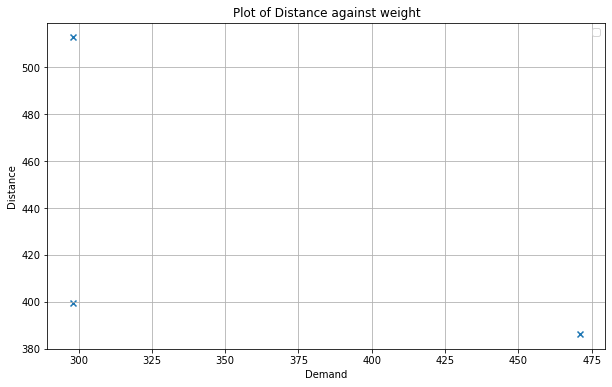

In [35]:
X1 = [Demand2,Demand3,Demand7]
X2 = [d2,d3,d7]
plt.figure(figsize=(10, 6))
plt.scatter(X1, X2, marker='x', label='')  # Using scatter to plot points without connecting lines
# Adding labels and title
plt.xlabel('Demand')
plt.ylabel('Distance')
plt.title('Plot of Distance against weight')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()
